In [27]:
model_list = ["resnet50", "resnet101", "resnet152", "vgg19", "vgg16", "unet", "deeplabv3", "mobilenet_v2", "alexnet", "bert"]
file_path = '/data/zbw/inference_system/MIG_MPS/log/'


QoS_map = {
    'resnet50': 108,
    'resnet101': 108,
    'resnet152': 108,
    'vgg16':  142,
    'vgg19': 142,
    'mobilenet_v2': 64,
    'unet': 120,
    'bert': 400,
    'deeplabv3': 300,
    'alexnet': 80,
}


half_QoS_map = {

}

for i in QoS_map.keys():
    half_QoS_map[i] = QoS_map[i]/2


class ConfigData:
    def __init__(self, sm, rps, p99):
        self.sm = int(sm)  # SM值
        self.RPS = int(rps)  # RPS值
        self.p99 = float(p99)  # P99值

    def __repr__(self):
        return f"ConfigData(SM: {self.sm}, RPS: {self.RPS}, P99: {self.p99})"

def parse_line(line):
    parts = line.strip().split(", ")
    SM = parts[0].split(": ")[1]
    P99 = parts[1].split(": ")[1]
    RPS = parts[2].split(": ")[1]
    return ConfigData(SM, RPS, P99)

def read_data_from_file(file_path):
    config_list = []
    with open(file_path, 'r') as file:
        for line in file:
            config = parse_line(line)
            config_list.append(config)
    return config_list



def find_max_rps_under_p99(config_list, sm_value, p99_threshold):
    max_rps = None
    for config in config_list:
        if config.sm == sm_value and config.p99 <= p99_threshold:
            if max_rps is None or config.RPS > max_rps:
                max_rps = config.RPS
    return max_rps

model_QPS_list = {}
for i in model_list:
    model_log_path = file_path + f"{i}_MPS_RPS"
    config_list = read_data_from_file(model_log_path)
    SM_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    model_QPS_list[i] = []
    for sm_value in SM_list:
        QPS = find_max_rps_under_p99(config_list, sm_value, half_QoS_map.get(i))
        model_QPS_list[i].append(QPS)


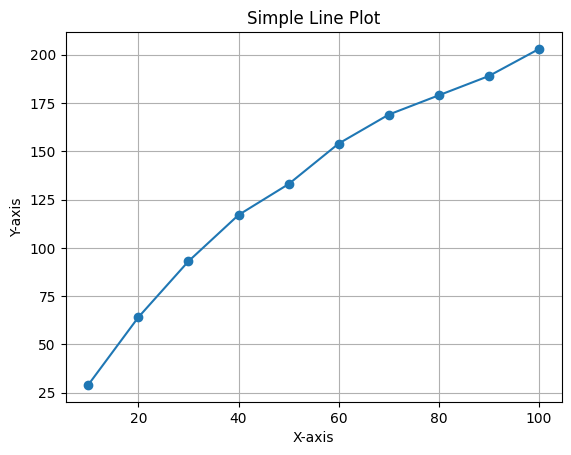

In [25]:
import matplotlib.pyplot as plt



# 假设这些是示例数据
SM_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
QPS_list = [5500, 5593, 5616, 5000, 5250, 5375, 5437, 5468, 5101, 5106]  # 用你的实际数据替换这些

# 创建图形和子图
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # 创建2x5的子图网格

# 展平子图数组以方便迭代
axes = axes.flatten()

# 遍历每个模型并绘制子图
for i, model in enumerate(model_list):
    ax = axes[i]
    QPS_list = model_QPS_list.get(model)
    ax.plot(SM_list, QPS_list, marker='o')
    ax.set_title(model)
    ax.set_xlabel("SM")
    ax.set_ylabel("QPS")
    ax.grid(True)

# 调整布局以防止子图重叠
plt.tight_layout()

# 显示图形
plt.show()


In [30]:
file_path = '/data/zbw/inference_system/MIG_MPS/log/pairs_MPS_QPS'
def parse_line(line):
    parts = line.strip().split(", ")
    config = parts[0].split(": ")[1]
    p99 = float(parts[1].split(": ")[1])
    return {"config": config, "p99": p99}

def read_data_from_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(parse_line(line))
    return data

def find_max_batch_sum(data, p99_threshold):
    max_batch_sum = 0
    max_batch_config = None

    # 遍历数据，每两行为一组
    for i in range(0, len(data), 2):
        group = data[i:i+2]
        
        # 检查两行数据的P99值是否都不超过阈值
        if all(entry["p99"] <= p99_threshold for entry in group):
            # 计算两行的batch值
            batch_sum = sum(int(entry["config"].split("+")[1]) for entry in group)
            
            # 更新最大batch值
            if batch_sum > max_batch_sum:
                max_batch_sum = batch_sum
                max_batch_config = group

    return max_batch_sum, max_batch_config


data = read_data_from_file(file_path)

# 设置P99的阈值
p99_threshold = 50

max_batch_sum, max_batch_config = find_max_batch_sum(data, p99_threshold)

# 输出结果
if max_batch_config:
    print(f"最大合法batch值之和: {max_batch_sum}")
    for entry in max_batch_config:
        print(f"Config: {entry['config']}, P99: {entry['p99']}")
else:
    print("没有找到合法的batch组合")


最大合法batch值之和: 64
Config: 50+31, P99: 48.84672164916992
Config: 50+33, P99: 49.71582889556885
